In [1]:
from fastai.vision.all import *

In [2]:
from torchvision.models import vgg19, vgg16

In [3]:
feat_net = vgg19(pretrained=True).features.cuda().eval()

In [4]:
for p in feat_net.parameters(): p.requries_grad=False

In [5]:
layers = [feat_net[i] for i in [1, 6, 11, 20, 29, 22]]; layers

[ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True)]

In [6]:
_vgg_config = {
    'vgg16' : [1, 11, 18, 25, 20],
    'vgg19' : [1, 6, 11, 20, 29, 22]
}

In [7]:
def _get_layers(arch:str, pretrained=True):
    "Get the layers and arch for a VGG Model (16 and 19 are supported only)"
    feat_net = vgg19(pretrained=pretrained).cuda() if arch.find('9') > 1 else vgg16(pretrained=pretrained).cuda()
    config = _vgg_config.get(arch)
    features = feat_net.features.cuda().eval()
    for p in features.parameters(): p.requires_grad=False
    return feat_net, [features[i] for i in config]

In [8]:
def get_feats(arch:str, pretrained=True):
    "Get the features of an architecture"
    feat_net, layers = _get_layers(arch, pretrained)
    hooks = hook_outputs(layers, detach=False)
    def _inner(x):
        feat_net(x)
        return hooks.stored
    return _inner

In [9]:
feats = get_feats('vgg19')

In [10]:
url = 'https://static.greatbigcanvas.com/images/singlecanvas_thick_none/megan-aroon-duncanson/little-village-abstract-art-house-painting,1162125.jpg'

In [11]:
!wget {url} -O style.jpg

--2022-04-24 16:14:50--  https://static.greatbigcanvas.com/images/singlecanvas_thick_none/megan-aroon-duncanson/little-village-abstract-art-house-painting,1162125.jpg
Resolving static.greatbigcanvas.com (static.greatbigcanvas.com)... 34.197.102.102, 54.160.121.216
Connecting to static.greatbigcanvas.com (static.greatbigcanvas.com)|34.197.102.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 484954 (474K) [image/jpeg]
Saving to: 'style.jpg'

     0K .......... .......... .......... .......... .......... 10% 1.14M 0s
    50K .......... .......... .......... .......... .......... 21% 1.16M 0s
   100K .......... .......... .......... .......... .......... 31% 4.95M 0s
   150K .......... .......... .......... .......... .......... 42% 5.93M 0s
   200K .......... .......... .......... .......... .......... 52% 1.14M 0s
   250K .......... .......... .......... .......... .......... 63% 9.85M 0s
   300K .......... .......... .......... .......... .......... 73% 5.41

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


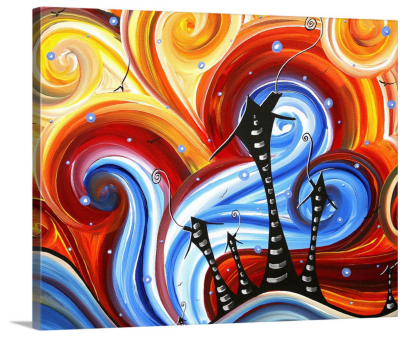

In [12]:
fn = 'style.jpg'
dset = Datasets(fn, tfms=[PILImage.create])
dl = dset.dataloaders(after_item=[ToTensor()], after_batch=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)], bs=1)
dl.show_batch(figsize=(7,7))


In [13]:
style_im = dl.one_batch()[0]
style_im.shape

torch.Size([1, 3, 831, 1000])

In [14]:
def get_style_im(url):
    download_url(url, 'style.jpg')
    fn = 'style.jpg'
    dset = Datasets(fn, tfms=[PILImage.create])
    dl = dset.dataloaders(after_item=[ToTensor()], after_batch=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)], bs=1)
    return dl.one_batch()[0]

In [15]:
im_feats = feats(style_im)
for feat in im_feats:
    print(feat.shape)

C:\Users\dhruv\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 64, 831, 1000])
torch.Size([1, 128, 415, 500])
torch.Size([1, 256, 207, 250])
torch.Size([1, 512, 103, 125])
torch.Size([1, 512, 51, 62])
torch.Size([1, 512, 103, 125])


In [16]:
def gram(x:Tensor):
    "Transpose a tensor based on c,w,h"
    n, c, h, w = x.shape
    x = x.view(n, c, -1)
    return (x @ x.transpose(1, 2))/(c*w*h)

In [17]:
im_grams = [gram(f) for f in im_feats]

In [18]:
for feat in im_grams:
    print(feat.shape)

torch.Size([1, 64, 64])
torch.Size([1, 128, 128])
torch.Size([1, 256, 256])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])


In [19]:
def get_stl_fs(fs): return fs[:-1]

In [20]:
def style_loss(inp:Tensor, out_feat:Tensor):
    "Calculate style loss, assumes we have `im_grams`"
    # Get batch size
    bs = inp[0].shape[0]
    loss = []
    # For every item in our inputs
    for y, f in zip(*map(get_stl_fs, [im_grams, inp])):
        # Calculate MSE
        loss.append(F.mse_loss(y.repeat(bs, 1, 1), gram(f)))
    # Multiply their sum by 30000
    return 3e5 * sum(loss)

In [21]:
class FeatureLoss(Module):
    "Combines two losses and features into a useable loss function"
    def __init__(self, feats, style_loss, act_loss):
        store_attr()
        self.reset_metrics()

    def forward(self, pred, targ):
        # First get the features of our prediction and target
        pred_feat, targ_feat = self.feats(pred), self.feats(targ)
        # Calculate style and activation loss
        style_loss = self.style_loss(pred_feat, targ_feat)
        act_loss = self.act_loss(pred_feat, targ_feat)
        # Store the loss
        self._add_loss(style_loss, act_loss)
        # Return the sum
        return style_loss + act_loss

    def reset_metrics(self):
        # Generates a blank metric
        self.metrics = dict(style = [], content = [])

    def _add_loss(self, style_loss, act_loss):
        # Add to our metrics
        self.metrics['style'].append(style_loss)
        self.metrics['content'].append(act_loss)

In [22]:
def act_loss(inp:Tensor, targ:Tensor):
    "Calculate the MSE loss of the activation layers"
    return F.mse_loss(inp[-1], targ[-1])

In [23]:
loss_func = FeatureLoss(feats, style_loss, act_loss)

In [24]:
## the architecture

In [25]:
class ReflectionLayer(Module):
    "A series of Reflection Padding followed by a ConvLayer"
    def __init__(self, in_channels, out_channels, ks=3, stride=2):
        reflection_padding = ks // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, ks, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

In [26]:
ReflectionLayer(3, 3)

ReflectionLayer(
  (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
  (conv2d): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2))
)

In [27]:
class ResidualBlock(Module):
    "Two reflection layers and an added activation function with residual"
    def __init__(self, channels):
        self.conv1 = ReflectionLayer(channels, channels, ks=3, stride=1)
        self.in1 = nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ReflectionLayer(channels, channels, ks=3, stride=1)
        self.in2 = nn.InstanceNorm2d(channels, affine=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out

In [28]:
ResidualBlock(3)

ResidualBlock(
  (conv1): ReflectionLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  )
  (in1): InstanceNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv2): ReflectionLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  )
  (in2): InstanceNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (relu): ReLU()
)

In [29]:
class UpsampleConvLayer(Module):
    "Upsample with a ReflectionLayer"
    def __init__(self, in_channels, out_channels, ks=3, stride=1, upsample=None):
        self.upsample = upsample
        reflection_padding = ks // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, ks, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

In [30]:
class TransformerNet(Module):
    "A simple network for style transfer"
    def __init__(self):
        # Initial convolution layers
        self.conv1 = ReflectionLayer(3, 32, ks=9, stride=1)
        self.in1 = nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ReflectionLayer(32, 64, ks=3, stride=2)
        self.in2 = nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ReflectionLayer(64, 128, ks=3, stride=2)
        self.in3 = nn.InstanceNorm2d(128, affine=True)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(128, 64, ks=3, stride=1, upsample=2)
        self.in4 = nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64, 32, ks=3, stride=1, upsample=2)
        self.in5 = nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ReflectionLayer(32, 3, ks=9, stride=1)
        # Non-linearities
        self.relu = nn.ReLU()

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y

In [31]:
net = TransformerNet()

In [32]:
path = untar_data(URLs.COCO_SAMPLE)

In [33]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(0.1, seed=42),
                   item_tfms=[Resize(224)],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])

In [34]:
dls = dblock.dataloaders(path, bs=5)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


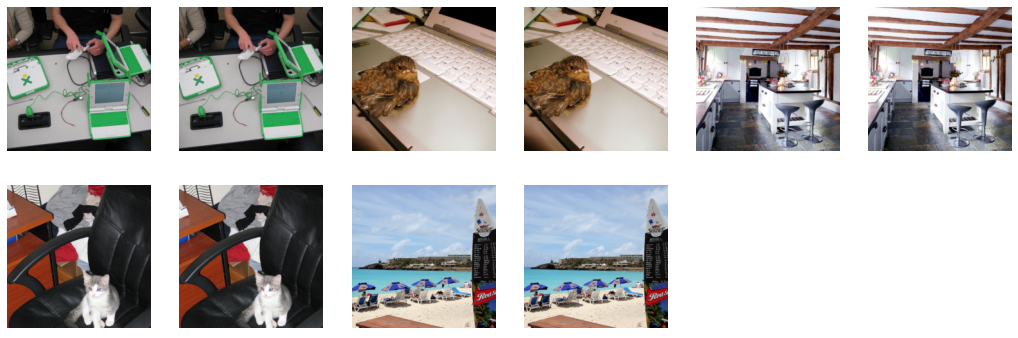

In [35]:
dls.show_batch()

In [36]:
learn = Learner(dls, TransformerNet(), loss_func=loss_func)

In [37]:
learn.summary()

TransformerNet (Input shape: 5)
Layer (type)         Output Shape         Param #    Trainable 
                     []                  
ReflectionPad2d                                                
____________________________________________________________________________
                     5 x 32 x 224 x 224  
Conv2d                                    7808       True      
InstanceNorm2d                            64         True      
____________________________________________________________________________
                     []                  
ReflectionPad2d                                                
____________________________________________________________________________
                     5 x 64 x 112 x 112  
Conv2d                                    18496      True      
InstanceNorm2d                            128        True      
____________________________________________________________________________
                     []                  
Re

C:\Users\dhruv\anaconda3\lib\site-packages\fastai\callback\schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=6.30957365501672e-05)

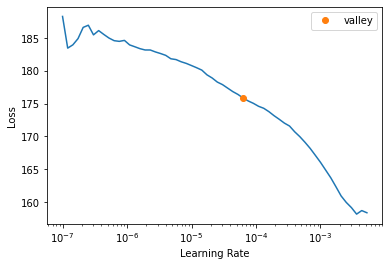

In [38]:
learn.lr_find()

In [39]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,time
0,23.663258,23.659100,27:57


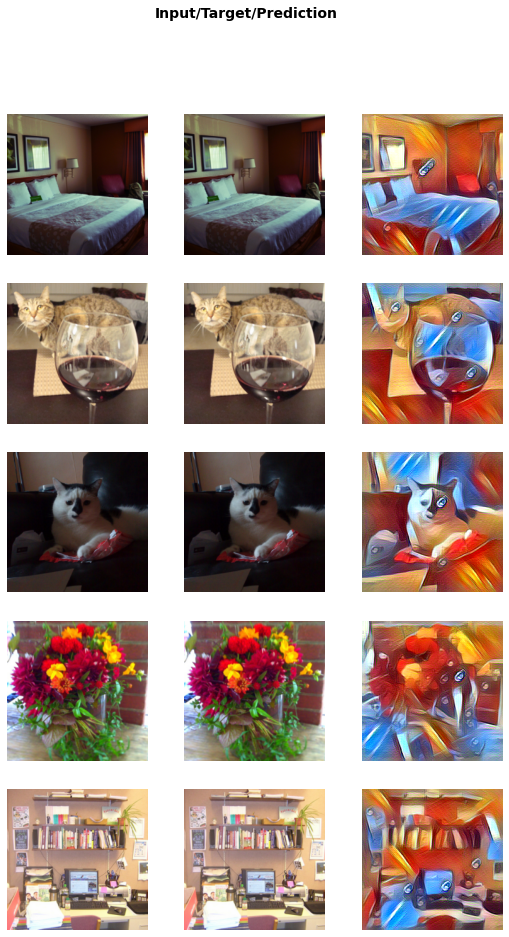

In [40]:
learn.show_results()

In [41]:
learn.save('stage-1')

Path('models/stage-1.pth')

<AxesSubplot:>

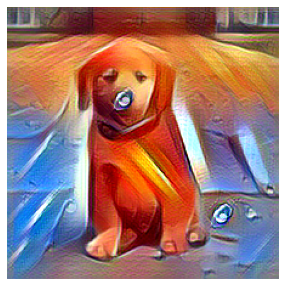

In [43]:
learn.predict('dog.jpg')[0].show()

In [44]:
dset = Datasets('dog.jpg', tfms=[PILImage.create])
dl = dset.dataloaders(after_item=[ToTensor()], after_batch=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)], bs=1)


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [45]:
t_im = dl.one_batch()[0]

In [46]:
with torch.no_grad():
    res = learn.model(t_im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:>

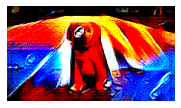

In [47]:
TensorImage(res[0]).show()

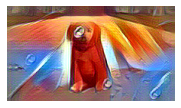

In [48]:
dec_res = dl.decode_batch(tuplify(res))[0][0]
dec_res.show();